In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [2]:
%matplotlib inline

In [7]:
with open("notMNIST_small/J.pickle",'rb') as file:
    data = pickle.load(file)

In [43]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
train_folder_name = "notMNIST_large"
test_folder_name = "notMNIST_small"
letters = ['A','B','C','D','E','F','G','H','I','J']
train_pickle_filenames = []
test_pickle_filenames = []


for letter in letters:
    train_pickle_filenames.append(train_folder_name + '/' + letter + '.pickle')
    test_pickle_filenames.append(test_folder_name + '/' + letter + '.pickle')

def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    print('Processing ' + str(label))
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            



In [44]:
  
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_pickle_filenames, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_pickle_filenames, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Processing 0
Processing 1
Processing 2
Processing 3
Processing 4
Processing 5
Processing 6
Processing 7
Processing 8
Processing 9
Processing 0
Processing 1
Processing 2
Processing 3
Processing 4
Processing 5
Processing 6
Processing 7
Processing 8
Processing 9
Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [45]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

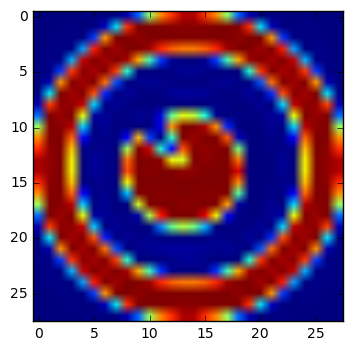

In [50]:
plt.imshow(train_dataset[109])

In [51]:
train_labels[109]

0

In [52]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [53]:
print(train_dataset)

[[[-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  ..., 
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]]

 [[-0.5        -0.49607843 -0.5        ..., -0.49607843 -0.49607843 -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.4254902  -0.5        -0.49607843]
  [-0.5        -0.5        -0.5        ...,  0.29215688 -0.43725491 -0.5       ]
  ..., 
  [-0.5        -0.49215686 -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.46078432 -0.38235295 -0.40196079 ..., -0.5        -0.5        -0.5       ]
  [ 0.0254902   0.40196079  0.30784315 ..., -0.5        -0.5        -0.5       ]]

 [[-0.5 